In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

In [2]:
sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'

In [3]:
%matplotlib widget

# ATARI Sammy Interface

This user example details basic use of the ATARI/SAMMY interface module. 
The example given here shows how to do individual sammy runs using the NV or IQ solution scheme.
The AutoFit example will detail sammy interface with YW scheme that can be used for automatic evaluations or simultaneous data fitting.

In [4]:
### setup the reaction model and sample a resonance
Ta_pair = Particle_Pair()      

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=8.79,
                       gn2_avg=465,
                       gn2_dof=1,
                       gg2_avg=350,
                       gg2_dof=1000)

# setup experimental transmission model
exp_model_T = Experimental_Model()


# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template(
    'template_T.inp', Ta_pair, exp_model_T, rto)
exp_model_T.template = os.path.realpath('template_T.inp')



In [5]:
### Generate syndat from measurement models
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import Syndat_Model, syndatOPT


generative = Transmission_RPI()
reductive = Transmission_RPI()

synOPT = syndatOPT(calculate_covariance=True, explicit_covariance=True)

synT = Syndat_Model(
              exp_model_T,
              generative,
              reductive,
              synOPT)
## need to test syndat covariance generation with different tof ordering !!!

synT.sample(Ta_pair, 
            sammyRTO=rto,
            num_samples=1)

In [6]:
vars(generative.model_parameters)

{'trigo': (9758727, 0),
 'trigs': (18476117, 0),
 'm1': (1, 0.016),
 'm2': (1, 0.008),
 'm3': (1, 0.018),
 'm4': (1, 0.005),
 'ks': (0.563, 0.02402339737495515),
 'ko': (1.471, 0.05576763648617445),
 'b0s': (9.9, 0.1),
 'b0o': (13.4, 0.7),
 'a_b': ([582.7768594580712, 0.05149689096209191],
  [[1143.95753, 0.142659922], [0.142659922, 2.19135003e-05]]),
 'open_neutron_spectrum':                tof            bw    ct        dct           E
 0    183110.960936  9.999999e-08  1134  33.674916  200.200037
 1    183010.960948  9.999998e-08  1153  33.955854  200.422933
 2    182910.960963  1.000001e-07  1124  33.526109  200.646202
 3    182810.960863  9.999996e-08  1177  34.307434  200.869845
 4    182710.960904  1.000001e-07  1187  34.452866  201.093861
 ..             ...           ...   ...        ...         ...
 184  164710.960895  9.999999e-08  1334  36.523965  248.453308
 185  164610.960907  9.999995e-08  1256  35.440090  248.761496
 186  164510.960956  1.000000e-07  1266  35.580894  24

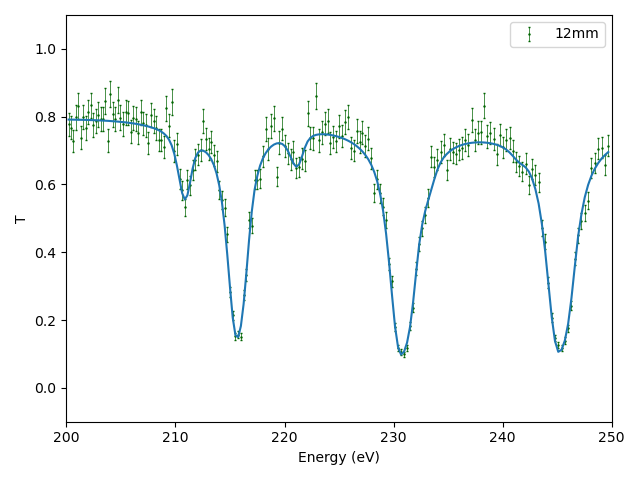

In [7]:
datasample = synT.samples[0]
data = datasample.pw_reduced


figure()
errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')
plot(data.E, data.true)
ylabel("T")

xlim([200,250])
ylim([-0.1,1.1])
legend()
xlabel('Energy (eV)')
tight_layout()

In [8]:
### Option to read in idc or you can just pass to sammy a filepath


# def read_idc(filepath):
#     data = {
#         'J': {},
#         'C': None,
#         'stat': None
#     }

#     with open(filepath, 'r') as f:
#         num_params = None
#         in_partial_derivatives = False
#         in_uncertainties = False
#         in_correlations = False
#         for line in f.readlines():
            
#             if line.lower().startswith("nu"):
#                 num_params = int(line.split()[-1])
            
#             elif line.lower().startswith("free-forma"):
#                 in_partial_derivatives = True

#             elif line.lower().startswith("uncertaint"):
#                 in_partial_derivatives = False
#                 in_uncertainties = True
            
#             elif line.lower().startswith("correlatio"):
#                 in_uncertainties = False
#                 in_correlations = True

#             elif in_partial_derivatives:
#                 splitline = line.split()
#                 E = float(splitline[0])
#                 stat_unc = float(splitline[1])
#                 derivatives = [float(x) for x in splitline[2:]]
#                 data['J'][E] = {'stat_unc': stat_unc, 'derivatives': derivatives}
                
#             elif in_uncertainties:
#                 uncertainties = [float(e) for e in line.split()]
#                 data['C'] = np.diag(uncertainties)

#             elif in_correlations:
#                 assert isinstance(num_params, int)
#                 correlations = []
#                 for _ in range(num_params):
#                     line = f.readline().strip().split()
#                     correlations.append([float(x) for x in line])

#     data['stat'] = None  # You need to fill in the logic for reading the 'stat' data

#     return data

# Usage
# filepath = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-1mm.idc'
# read_data = read_idc(filepath)

In [9]:
print(datasample.covariance_data.keys())

dict_keys(['CovT', 'Cov_sys', 'Jac_sys', 'diag_stat'])


In [10]:
datasample.covariance_data['CovT']

E,200.200037,200.422933,200.646202,200.869845,201.093861,201.318253,201.543020,201.768164,201.993685,202.219584,...,246.920925,247.226266,247.532173,247.838648,248.145693,248.453308,248.761496,249.070258,249.379595,249.689508
200.200037,0.001223,0.000354,0.000336,0.000368,0.000383,0.000340,0.000369,0.000353,0.000375,0.000384,...,0.000208,0.000228,0.000238,0.000255,0.000300,0.000305,0.000325,0.000326,0.000303,0.000329
200.422933,0.000354,0.001167,0.000332,0.000363,0.000378,0.000336,0.000364,0.000349,0.000370,0.000379,...,0.000206,0.000225,0.000235,0.000252,0.000296,0.000301,0.000321,0.000322,0.000299,0.000325
200.646202,0.000336,0.000332,0.001060,0.000345,0.000359,0.000319,0.000346,0.000331,0.000351,0.000360,...,0.000195,0.000213,0.000223,0.000239,0.000281,0.000286,0.000305,0.000306,0.000284,0.000309
200.869845,0.000368,0.000363,0.000345,0.001281,0.000393,0.000349,0.000378,0.000362,0.000385,0.000394,...,0.000214,0.000234,0.000244,0.000262,0.000308,0.000313,0.000334,0.000335,0.000311,0.000338
201.093861,0.000383,0.000378,0.000359,0.000393,0.001401,0.000364,0.000394,0.000378,0.000401,0.000411,...,0.000223,0.000244,0.000254,0.000273,0.000320,0.000326,0.000348,0.000349,0.000324,0.000352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248.453308,0.000305,0.000301,0.000286,0.000313,0.000326,0.000290,0.000314,0.000301,0.000319,0.000327,...,0.000178,0.000194,0.000203,0.000217,0.000255,0.000877,0.000277,0.000278,0.000258,0.000281
248.761496,0.000325,0.000321,0.000305,0.000334,0.000348,0.000309,0.000335,0.000320,0.000340,0.000349,...,0.000189,0.000207,0.000216,0.000231,0.000272,0.000277,0.001000,0.000296,0.000275,0.000299
249.070258,0.000326,0.000322,0.000306,0.000335,0.000349,0.000310,0.000336,0.000322,0.000342,0.000350,...,0.000190,0.000207,0.000217,0.000232,0.000273,0.000278,0.000296,0.000988,0.000276,0.000300
249.379595,0.000303,0.000299,0.000284,0.000311,0.000324,0.000288,0.000312,0.000298,0.000317,0.000325,...,0.000176,0.000192,0.000201,0.000216,0.000253,0.000258,0.000275,0.000276,0.000873,0.000278


In [11]:
# ### decomposed covariance test
# stat = copy(datasample.covariance_data["diag_stat"])
# CT = copy(datasample.covariance_data['CovT'])
# J = copy(datasample.covariance_data['Jac_sys'])
# C = copy(datasample.covariance_data['Cov_sys'])
# # C = np.diag(np.diag(C))
# test = J.T@C@J
# test.index.name = None
# assert(np.max(abs((np.diag(stat.var_stat) + test) - CT)) == 0.0)

# Fit the data with sammy

In [12]:
rto.bayes=True
rto.get_ECSCM = True
rto.ECSCM_rxn = 'transmission'

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    Ta_pair.resonance_ladder,
    os.path.realpath('template_T.inp'),
    exp_model_T,
    # energy_grid=exp_model_T.energy_grid
    experimental_data=data,
    experimental_covariance = datasample.covariance_data
)

sammyINP.initial_parameter_uncertainty=10

# std = 0.01
# data.exp = np.random.default_rng().normal(data.true, std)
# data.exp_unc = std

sammyINP.experimental_data = data
sammyINP.resonance_ladder["varyE"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(Ta_pair.resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
print(sammyOUT2.chi2_post)
print(sammyOUT2.chi2n_post)

315.217
1.66781


BACKGround functions
EXPON 0 0 582.77685 33.822441 0.0514968 0.0046811 

NORMALIZATION AND BACKGROUND ARE NEXT
1.0000000        0.0                                         3
0.0384200

!! when fitting background or normalization, the output lst has an additional column I need to be robust to.

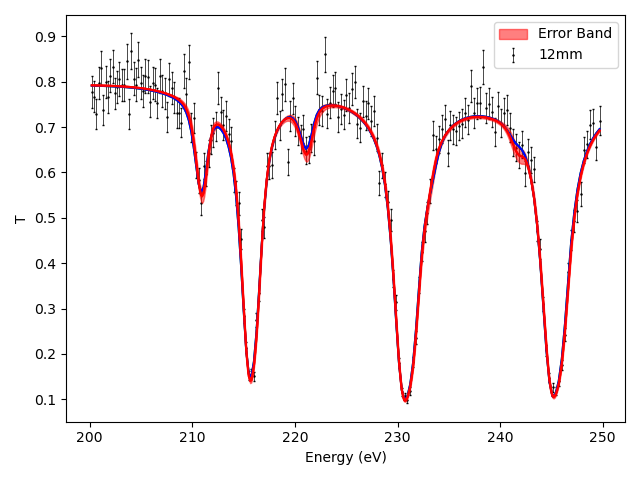

In [13]:

### Plot 
figure()

errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(data.E, data.true, 'g')

plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans, 'b')
plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_trans_bayes, 'r')

# plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_xs, 'b')
# plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_xs_bayes, 'r')
# # plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# # sammyOUT_old = copy(sammyOUT2)

x = sammyOUT2.est_df.E
y = sammyOUT2.est_df.theo
y_err=  sammyOUT2.est_df.theo_unc #
# y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
plot(x, y, 'r')

ylabel("T")

# xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


# figure()
# imshow(sammyOUT2.ECSCM)
# colorbar()

In [14]:
ladder = copy(sammyOUT2.par_post)
print(ladder)
Ta_pair.spin_groups

            E          Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0  210.867484  593.241718   1.117273    1.0     1.0      1.0   1.0
1  215.692345  638.541477  10.238018    1.0     1.0      1.0   1.0
2  221.082676  787.791864   0.713014    1.0     1.0      1.0   1.0
3  230.838708  650.631478  21.514491    1.0     1.0      1.0   1.0
4  232.900425  427.243923   0.223651    1.0     1.0      1.0   1.0
5  241.559659  327.028681   0.181485    1.0     1.0      1.0   1.0
6  245.317225  713.247317  22.930668    1.0     1.0      1.0   1.0


{3.0: {'Jpi': 3.0,
  'J_ID': 1,
  '<D>': 8.79,
  '<gn2>': 465,
  'n_dof': 1,
  '<gg2>': 350,
  'g_dof': 1000,
  'quantiles': {'D01': 0.9943384234177864,
   'D99': 21.284662911191237,
   'gn01': 0.07304585392801136,
   'gn99': 3085.2269194748646,
   'gg01': 314.61935642536463,
   'gg99': 387.43914802327606,
   'gt01': 314.69240227929265,
   'gt99': 3472.666067498141},
  'chs': 1,
  'Ls': [0]}}

In [15]:
from ATARI.utils.atario import expand_sammy_ladder_2_atari

expand_sammy_ladder_2_atari(Ta_pair, ladder)
ladder

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,gg2,gn2,Jpi,L
0,210.867484,593.241718,1.117273,1.0,1.0,1.0,1.0,296.620859,21.667875,3.0,0.0
1,215.692345,638.541477,10.238018,1.0,1.0,1.0,1.0,319.270738,196.318136,3.0,0.0
2,221.082676,787.791864,0.713014,1.0,1.0,1.0,1.0,393.895932,13.504633,3.0,0.0
3,230.838708,650.631478,21.514491,1.0,1.0,1.0,1.0,325.315739,398.784836,3.0,0.0
4,232.900425,427.243923,0.223651,1.0,1.0,1.0,1.0,213.621961,4.127124,3.0,0.0
5,241.559659,327.028681,0.181485,1.0,1.0,1.0,1.0,163.514341,3.288437,3.0,0.0
6,245.317225,713.247317,22.930668,1.0,1.0,1.0,1.0,356.623658,412.301175,3.0,0.0


In [16]:
# samples = 100

# cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
# cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

# for i in range(samples):
#     # synT.run(sammyOUT.pw)
#     data.exp = np.random.default_rng().normal(synT.data.true, std)
#     data.exp_unc = std
#     sammyINP.experimental_data = synT.data
#     sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#     residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#     cov_true += residual.T@residual
#     cov_est += sammyOUT2.ECSCM
#     # true.append(cov_true)
#     # est.append(cov_est)

In [17]:
# iest = 0
# fig, axes = subplots(1,2, figsize=(10,4))
# # im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# # im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
# im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 8e-5))
# im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 8e-5))
# axes[0].set_title("empirical")

# axes[1].set_title("estimated")
# # for ax in axes:
# colorbar(im1)

# colorbar(im2)

# print("Empirical Fnorm")
# print(np.linalg.norm(cov_true/(samples), ord='fro'))
# print("Estimated Fnorm")
# print(np.linalg.norm(cov_est/(samples-1), ord='fro'))

In [18]:
# ### Plot 
# figure()

# # errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
# #                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# # plot(synT.data.E, synT.data.true, 'g')
# plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
# plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


# xlim([200,225])
# # ylim([-0.1,1.1])
# legend()

# xlabel('Energy (eV)')
# tight_layout()

In [19]:
# # result_dict = {}
# # stds = [0.1, 0.01, 0.001, 0.0001]
# stds = [0.00001, 0.05]

# for istd in stds:
#     samples = 1000
#     cov_true = np.zeros([len(sammyOUT2.pw), len(sammyOUT2.pw)])
#     cov_est = np.zeros([len(sammyOUT2.est_df), len(sammyOUT2.est_df)])
#     for i in range(samples):
#         # synT.run(sammyOUT.pw)
#         synT.data.exp = np.random.default_rng().normal(synT.data.true, istd)
#         synT.data.exp_unc = istd
#         sammyINP.experimental_data = synT.data
#         sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#         residual = np.atleast_2d(
#             sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#         cov_true += residual.T@residual
#         cov_est += sammyOUT2.ECSCM
        
#     result_dict[istd] = [cov_true, cov_est]

In [20]:
# stds = [1.0, 0.1, 0.05, 0.01, 0.001, 0.0001]
# true= []
# est = []

# for istd in stds:
#     res = result_dict[istd]
#     cov_true = res[0]
#     cov_est = res[1]
#     print(istd)
#     # print("Empirical Fnorm: ", np.linalg.norm(cov_true/(samples), ord='fro'))
#     # print("Estimated Fnorm: ", np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     # true.append(np.linalg.norm(cov_true/(samples), ord='fro'))
#     # est.append(np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     print("Empirical Fnorm: ", np.sum(np.diag(cov_true)**2/(samples)))
#     print("Estimated Fnorm: ", np.sum(np.diag(cov_est)**2/(samples-1)))
#     true.append(np.sum(np.diag(cov_true)**2/(samples)))
#     est.append(np.sum(np.diag(cov_est)**2/(samples-1)))

In [21]:
# figure()
# plot(stds, true, '.', label='Empirical')
# plot(stds, est, '.r', label='Estimate')
# xscale("log")
# yscale("log")
# legend()
# # ylabel("Noise Level")
# xlabel("Noise Level")